# Calculate the Magnetic Kirchhoff Index (MKI) for a planar magnetic arrays

`-` This code requires **Python 3.11.4** or later versions.

`-` This code is designed to compute the **Magnetic Kirchhoff Index**, a graph-theoretic metric that characterizes the magnetic flux transfer capability and uniformity of planar magnetic cores in a magnetic coupler.

In [1]:
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt
import math as m 
from mpmath import mp

# 1. Establish the directional magnetic resistance model for materials

`-` This study assumes that the selected magnetic core materials have regular geometric shapes, where Ferrite PC95 has dimensions of 50 mm × 50 mm × 5 mm and is denoted as 2, while Nanocrystalline 1K107B has dimensions of 50 mm × 50 mm × 3 mm, with different stacking orientations along the X and Y axes represented by 0 and 1, respectively.

`-` Furthermore, each magnetic core unit possesses magnetic reluctance in four directions: x-, x+, y-, and y+.

In [2]:
def Reluctance(i):
    if i == 0:
        reluctances = [0.0250/(4.545*0.05*0.003), 0.0250/(4.545*0.05*0.003), 0.0250/(25740*0.05*0.003), 0.0250/(25740*0.05*0.003)]
    if i == 1:
        reluctances = [0.0250/(25740*0.05*0.003), 0.0250/(25740*0.05*0.003), 0.0250/(4.545*0.05*0.003), 0.0250/(4.545*0.05*0.003)]
    if i == 2:
        reluctances = [0.0250/(3302.09*0.050*0.005), 0.0250/(3302.09*0.050*0.005), 0.0250/(3302.09*0.050*0.005), 0.0250/(3302.09*0.050*0.005)] 

    return reluctances

# 2. Establish the magnetic circuit graph for the planar core array

`-` This function generates the magnetic network graph of a planar magnetic core array, where the center of each magnetic core unit is treated as a node, and the directional magnetic reluctance between adjacent units is incorporated as edge.

`-` The input parameter layout represents the unit arrangement matrix of the planar core array, where each element denotes the material type of the corresponding core unit. In this implementation, a 9×9 core array is used as an example.

In [3]:
def Get_graph(layout):
    
    # Retrieve the dimensions of the core arrangement matrix.
    row, col = np.shape(layout)
    
    a = 1
    b = 1
    node = []
    edge = {}
    nodes = {}
    pos = {}
    
    # Iterate through the core array to extract the edge weights and associated node information for each unit.
    for i, row in enumerate(layout):
        for j, element in enumerate(row):
            node.append('node'+str(a))
            nodes['node'+str(a)] = layout[i, j]
            pos['node'+str(a)] = (j, 9 - i)
            
            if i == 0 :
                if j != col-1 :
                    resist = Reluctance(layout[i, j])[1] + Reluctance(layout[i, j+1])[0]
                    edge['edge'+str(b)] = [('node'+str(a), 'node'+str(a+1)), resist]
                    b = b + 1
            
            if i != 0 :
                if j != col-1 :
                    resist = Reluctance(layout[i, j])[1] + Reluctance(layout[i, j+1])[0]
                    edge['edge'+str(b)] = [('node'+str(a), 'node'+str(a+1)), resist]
                    b = b + 1
                 
                resist = Reluctance(layout[i, j])[3] + Reluctance(layout[i-1, j])[2]
                edge['edge'+str(b)] = [('node'+str(a), 'node'+str(a - 9)), resist]
                b = b + 1
            
            a = a + 1
    
    # Add edges to the magnetic network graph G and assign weights to their associated nodes.
    G = nx.Graph()
    
    for i in range(len(edge)):
        node_1 = edge['edge'+str(i+1)][0][0]
        node_2 = edge['edge'+str(i+1)][0][1]
        edge_weight = edge['edge'+str(i+1)][1]
        G.add_edge(node_1, node_2, weight=edge_weight)
        
    
    # Set the node size and edge size for improved visualization of the magnetic network graph.
    node_size = 500
    edge_length = 0.2

    # Set the background canvas size.
    plt.figure(figsize=(10, 10))

    # Draw the nodes of the magnetic network graph and add corresponding labels.
    node_positions = copy.deepcopy(pos)
    nx.draw(G, pos=node_positions, with_labels=False, font_weight='bold', node_size=node_size, arrows=True)

    for node_label, (x, y) in node_positions.items():
        plt.text(x, y, node_label[4:], fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.3'))

    # Draw the edges of the magnetic network graph and annotate with corresponding weights.
    edge_labels = {(edge[0], edge[1]): f"{edge[2]['weight']:.2f}" for edge in G.edges(data=True)}
    edge_widths = [0.2 + 3 * edge[2]['weight'] for edge in G.edges(data=True)]
    
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_labels, font_color='red', font_size=8)

    
    plt.show()
    
    return G

# 3.Establish the multi-port network graph model 

`-` This module constructs the equivalent multi-port network model when the planar magnetic core array embedded in a magnetic coupler. The paper uses a rounded rectangular coil-type magnetic coupler as an example for modeling.

`-` The key parameters computed in this model include the **Incidence Matrix *Ac*** ,the **Diagonal Edge-permeance Matrix *W*** and the **Node-permeance Matrix *Y*** of the multi-port graph network. The detailed derivation and computation methods can be found in paper  "Reluctance Distance: A Graph Theory Insight for Planar Magnetic Arrays in Inductive Power Transfer".

In [4]:
# Construct the edge dict and corresponding node list for the magnetic core array.
def Edge_weights(G):
    # Extract the edge list from the magnetic network graph.
    nodes_list = list(G.nodes())
    edges_list = list(G.edges())
    
    edge_weights = {}
    
    a = 1
    for edge in G.edges():
        source, target, weight = edge[0], edge[1], G.get_edge_data(edge[0], edge[1])['weight']
        edge_weights['edge'+str(a)] =[(source, target), weight]
        a = a + 1
    
    return edge_weights


# Compute the incidence matrix Ac based on the original magnetic network graph.
def Original_incidence_matrix(edge_weights, layout):
    rows = np.shape(layout)[0]*np.shape(layout)[1] # 81 nodes
    cols = len(edge_weights) # 144 egdes
    Ac_original = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            if 'node'+str(i+1) == edge_weights['edge'+str(j+1)][0][0]:
                Ac_original[i, j] = 1
            elif 'node'+str(i+1) == edge_weights['edge'+str(j+1)][0][1]:
                Ac_original[i, j] = -1
            else:
                Ac_original[i, j] = 0
        
    # Configure NumPy's print options to ensure the full display of matrices when queried in the Jupyter environment.
    np.set_printoptions(threshold=np.inf)
        
    return Ac_original


# Compute the diagonal permeance matrix W based on the original magnetic network graph.
def Original_edge_diagonal_permeance_matrix(edge_weights):
    diagonal = []

    for i in range(len(edge_weights)):
        
        # The weight value is defined as the reciprocal of the corresponding edge magnetic reluctance.
        diagonal.append(1/edge_weights['edge'+str(i+1)][1])
    
    W_original = np.diag(diagonal)
    
    return W_original


'''
Expand the graph's nodes and edges based on the spatial magnetic field distribution characteristics of the magnetic coupler, 
and construct the incidence matrix Ac and diagonal edge-permeance matrix W for the multi-port network.
'''
# Construct the 25 edges connecting the lumped node to the mutual inductance region core units.
Ac_right_up = np.zeros((81, 25))
index = [20, 21, 22, 23, 24, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 47, 48, 49, 50, 51, 56, 57, 58, 59, 60]  # The numbering of mutual inductance region magnetic core units is decremented by 1 to align with the index in the stored list in memory.
for j in range(np.shape(Ac_right_up)[1]):
    Ac_right_up[index[j],j] = -1

Ac_right_down = np.ones((1, 25))

Ac_left_down = np.zeros((1, 144))


'''
The newly constructed lumped node and its 25 edges are appended to the original incidence matrix Ac, 
while the corresponding edge weights are incorporated into the original diagonal edge-permeance matrix W.
'''
def Add_lumped_node(Ac_original, W_original, layout_nano):
    Ac_left_up = copy.deepcopy(Ac_original)

    Ac_up = np.concatenate((Ac_left_up, Ac_right_up), axis=1)
    Ac_down = np.concatenate((Ac_left_down, Ac_right_down), axis=1)

    Ac_new = np.concatenate((Ac_up, Ac_down), axis=0)

    w = [float(i) for i in np.diag(W_original)]
    for i in range(2,7):
        for j in range(2,7):     
            
            # The weight of the newly added edges is defined as the reciprocal of the magnetic reluctance in the Z-direction of the corresponding core unit.
            if layout_nano[i, j] == 2:
                w.append(1/(0.0025/(3302*0.05*0.05)))
            else:
                w.append(1/(0.0015/(25740*0.05*0.05)))
        
    W_new = np.diag(w)

    return Ac_new, W_new



'''
Construct 4×9 constraint nodes at the side surfaces of the outermost magnetic core units in the array. 
These nodes are then integrated with the existing incidence matrix Ac_new and diagonal edge-permeance matrix W_new to 
establish the multi-port network incidence matrix A_multiport and diagonal edge-permeance matrix W_multiport.
'''

# The weight of the edge between the constraint node and the core unit node is the reciprocal of the magnetic reluctance.
def Add_constraint_nodes(Ac_new, W_new, layout_nano):
    Ac_multiport = copy.deepcopy(Ac_new)
    W_multiport = copy.deepcopy(W_new)
    w = [float(i) for i in np.diag(W_multiport)]
    for j in range(9):
        new_column = np.zeros((82))
        new_column[j*9] = -1
        # Merge the new node and its corresponding edge into the incidence matrix
        Ac_multiport = np.concatenate((Ac_multiport, new_column[:, np.newaxis]), axis=1)
        # Add weight value of the new edge
        if layout_nano[j,0] == 2:
            w.append(1/(0.025/(3302*0.05*0.005)))
        elif layout_nano[j,0] == 0:
            w.append(1/(0.025/(4.545*0.05*0.003)))
        elif layout_nano[j,0] == 1:
            w.append(1/(0.025/(25740*0.05*0.003)))

        new_column = np.zeros((82))
        new_column[j*9+8] = -1
        Ac_multiport = np.concatenate((Ac_multiport, new_column[:, np.newaxis]), axis=1)
        if layout_nano[j,8] == 2:
            w.append(1/(0.025/(3302*0.05*0.005) ))
        elif layout_nano[j,8] == 0:
            w.append(1/(0.025/(4.545*0.05*0.003) ))
        elif layout_nano[j,8] == 1:
            w.append(1/(0.025/(25740*0.05*0.003) ))

                     
    for i in range(9):
        new_column = np.zeros((82))
        new_column[i] = -1
        Ac_multiport = np.concatenate((Ac_multiport, new_column[:, np.newaxis]), axis=1)
        if layout_nano[0,i] == 2:
            w.append(1/(0.025/(3302*0.05*0.005) ))
        elif layout_nano[0,i] == 0:
            w.append(1/(0.025/(25740*0.05*0.003) ))
        elif layout_nano[0,i] == 1:
            w.append(1/(0.025/(4.545*0.05*0.003) ))


        new_column = np.zeros((82))
        new_column[i+72] = -1
        Ac_multiport = np.concatenate((Ac_multiport, new_column[:, np.newaxis]), axis=1)
        if layout_nano[8,i] == 2:
            w.append(1/(0.025/(3302*0.05*0.005) ))
        elif layout_nano[8,i] == 0:
            w.append(1/(0.025/(25740*0.05*0.003) ))
        elif layout_nano[8,i] == 1:
            w.append(1/(0.025/(4.545*0.05*0.003) ))


    Ac_multiport_down_left = np.zeros((36,144+25))
    Ac_multiport_down_right = np.eye(36)
    Ac_multiport_down = np.concatenate((Ac_multiport_down_left, Ac_multiport_down_right), axis=1)

    Ac_multiport = np.concatenate((Ac_multiport, Ac_multiport_down), axis=0)
    W_multiport = np.diag(w)
          
    return Ac_multiport, W_multiport

'''
Calculate magnetic node-permeance matrix Y_laplace. Y_laplace is the all-node permeance matrix containing reference node j, with a determinant value of 0. 
Subsequently, the node-permeability matrix Y of the multi port network could be obtained by deleting row j and column j.
'''
def Magnetic_admittance_matrix(Ac_multiport, W_multiport):
    Y_laplace = np.dot(np.dot(Ac_multiport, W_multiport),np.transpose(Ac_multiport))
    np.set_printoptions(threshold=np.inf)
    
    return Y_laplace

# 4. Calculate the Magnetic Kirchhoff Index

`-` The effective distance between two points in the graph can be computed using the **Node-permeance Matrix *Y***, which is defined in this paper as the **'Reluctance Distance'**.

`-` The **Magnetic Kirchhoff Index(MKI)** is defined as the sum of specific magnetic reluctance distances associated with magnetic flux circulation.

In [5]:
def Magnetic_Kirchhoff(Y_laplace):
    MKI = 0
    # Characterizing magnetic flux conductivity between node i and node j.
    
    # Reduce the order of the matrix Y_laplace  to obtain node-permeance matrix Y, which is equivalent to performing A*W*A^T operation on (j,j) submatrix A of the correlation matrix Ac to obtain Y
    Y = np.delete(np.delete(Y_laplace, [81], axis=0), [81], axis=1)
    for i in range(81+1+36): 
        if i in [20, 21, 22, 23, 24, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 47, 48, 49, 50, 51, 56, 57, 58, 59, 60, 81]:
            pass
        else:
            Y_i_j = np.delete(np.delete(Y_laplace, [i, 81], axis=0), [i, 81], axis=1)
            MKI = MKI + np.linalg.det(Y_i_j)/np.linalg.det(Y)

    # Characterizing leakage flux confinement capability.
    for i in range(81+1, 81+1+36):
        for j in range(81):
            Y = np.delete(np.delete(Y_laplace, [i], axis=0), [i], axis=1)
            Y_i_j = np.delete(np.delete(Y_laplace, [i, j], axis=0), [i, j], axis=1)
            MKI = MKI + np.linalg.det(Y_i_j)/np.linalg.det(Y)

    
    return MKI

# 5. Example

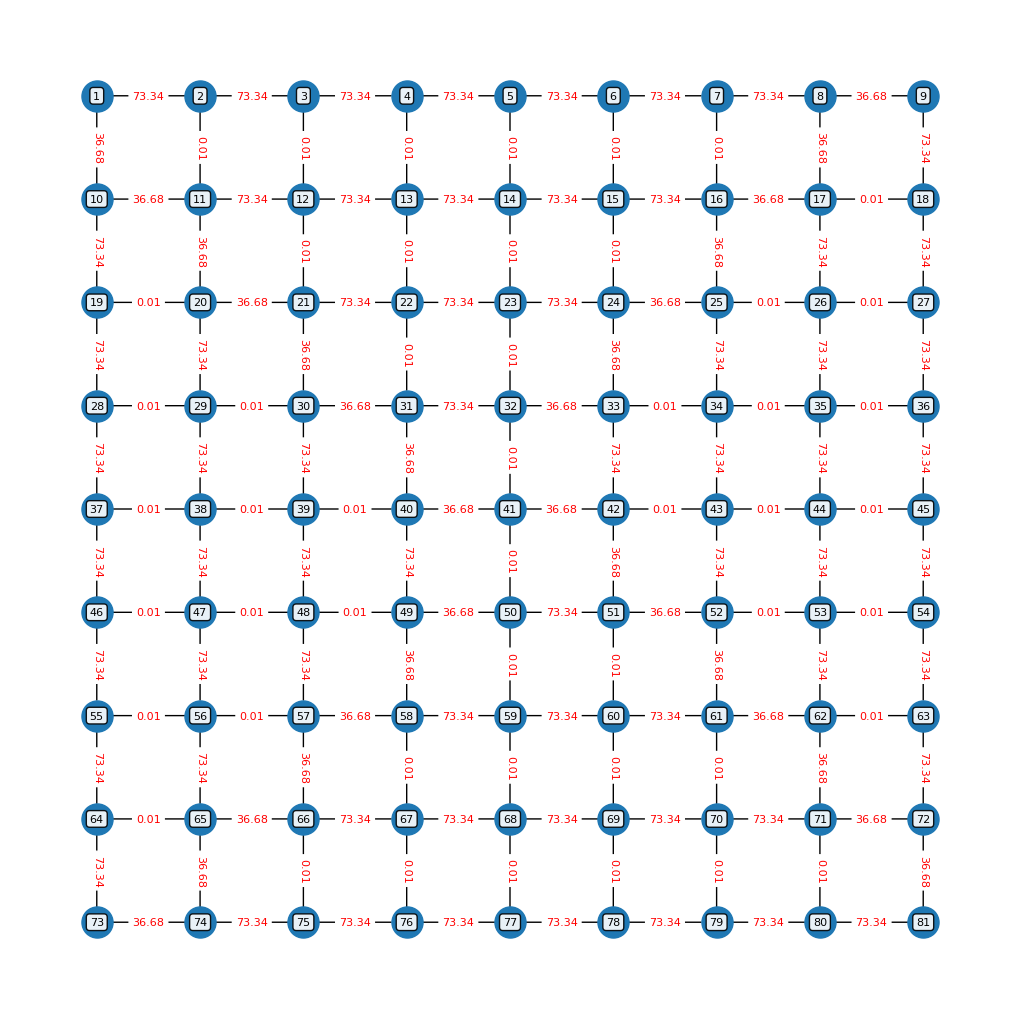

The Magnetic Kirchhoff Index of this core array is：86030.15499622011


In [6]:
# Case 3

layout = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 1],
                   [1, 0, 0, 0, 0, 0, 0, 1, 1],
                   [1, 1, 0, 0, 0, 0, 1, 1, 1],
                   [1, 1, 1, 0, 0, 1, 1, 1, 1],
                   [1, 1, 1, 1, 0, 1, 1, 1, 1],
                   [1, 1, 1, 1, 0, 0, 1, 1, 1],
                   [1, 1, 1, 0, 0, 0, 0, 1, 1],
                   [1, 1, 0, 0, 0, 0, 0, 0, 1],
                   [1, 0, 0, 0, 0, 0, 0, 0, 0]])


G = Get_graph(layout)
edge_weights = Edge_weights(G)
Ac_original = Original_incidence_matrix(edge_weights, layout)
W_original = Original_edge_diagonal_permeance_matrix(edge_weights)

Ac_new, W_new = Add_lumped_node(Ac_original, W_original, layout)
Ac_multiport, W_multiport = Add_constraint_nodes(Ac_new, W_new, layout)
Y_laplace = Magnetic_admittance_matrix(Ac_multiport, W_multiport)

MKI = Magnetic_Kirchhoff(Y_laplace)  
print('The Magnetic Kirchhoff Index of this core array is：{}'.format(MKI))